**Mount G-DRIVE**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Set path for working Directory**

In [2]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/thesis/transformer_model/FlowTransformer-master')


**Import all the libs and custom-frame works**

In [3]:
import os
import keras
import pandas as pd
from framework import NamedDatasetSpecifications, EvaluationDatasetSampling, FlowTransformer, FlowTransformerParameters
from implementations.classification_heads import *
from implementations.input_encodings import *
from implementations.pre_processings import StandardPreProcessing
from implementations.transformers.basic_transformers import BasicTransformer
from implementations.transformers.named_transformers import *

**Create list for encodings,classification_heads,type of transformers and datasets**

In [4]:
encodings = [
    NoInputEncoder(),
    RecordLevelEmbed(64),
    CategoricalFeatureEmbed(EmbedLayerType.Dense, 16),
    CategoricalFeatureEmbed(EmbedLayerType.Lookup, 16),
    CategoricalFeatureEmbed(EmbedLayerType.Projection, 16),
    RecordLevelEmbed(64, project=True)
]

classification_heads = [
    LastTokenClassificationHead(),
    FlattenClassificationHead(),
    GlobalAveragePoolingClassificationHead(),
    CLSTokenClassificationHead(),
    FeaturewiseEmbedding(project=False),
    FeaturewiseEmbedding(project=True),
]

transformers = [
    BasicTransformer(2, 128, n_heads=2),
    BasicTransformer(2, 128, n_heads=2, is_decoder=True),
    GPTSmallTransformer(),
    BERTSmallTransformer()
]

flow_file_path = "/content/drive/MyDrive/thesis/dataset/cleansed_dataset/train"
datasets = [
    ("CSE_CIC_IDS", os.path.join(flow_file_path, "output.csv"), NamedDatasetSpecifications.unified_flow_format,0.06, EvaluationDatasetSampling.LastRows),
    # ("UNSW_2018_IoT_Botnet_Full5pc_1.csv", os.path.join(flow_file_path, "UNSW_2018_IoT_Botnet_Full5pc_1.csv"), NamedDatasetSpecifications.nsl_kdd, 0.05, EvaluationDatasetSampling.RandomRows),
    ("NF-UNSW-NB15-v2", os.path.join(flow_file_path, "NF-UNSW-NB15-v2.csv"), NamedDatasetSpecifications.unified_flow_format, 0.1, EvaluationDatasetSampling.LastRows)
]

In [5]:
print(datasets[0])

('CSE_CIC_IDS', '/content/drive/MyDrive/thesis/dataset/cleansed_dataset/train/output.csv', <framework.DatasetSpecification object at 0x7f1333970160>, 0.06, <EvaluationDatasetSampling.LastRows: 0>)


In [6]:
pre_processing = StandardPreProcessing(n_categorical_levels=32)

# Define the transformer
ft = FlowTransformer(pre_processing=pre_processing,
                     input_encoding=encodings[0],
                     sequential_model=transformers[1],
                     classification_head=classification_heads[0],
                     params=FlowTransformerParameters(window_size=8, mlp_layer_sizes=[128], mlp_dropout=0.1))#change

# Load the specific dataset
dataset_name, dataset_path, dataset_specification, eval_percent, eval_method = datasets[1]
ft.load_dataset(dataset_name, dataset_path, dataset_specification, evaluation_dataset_sampling=eval_method, evaluation_percent=eval_percent)

# Build the transformer model
m = ft.build_model()
m.summary()

# Compile the model
m.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy'], jit_compile=True)

# Get the evaluation results
eval_results: pd.DataFrame
(train_results, eval_results, final_epoch) = ft.evaluate(m, batch_size=128, epochs=20, steps_per_epoch=64, early_stopping_patience=5)
print(eval_results)

Attempting to read dataset from path /content/drive/MyDrive/thesis/dataset/cleansed_dataset/train/NF-UNSW-NB15-v2.csv...
Set y to = Attack
Converting numerical columns to floats, and removing out of range values...
Applying pre-processing to numerical values
[Numerical 1 / 28] Processing numerical column NUM_PKTS_512_TO_1024_BYTES...
[Numerical 2 / 28] Processing numerical column TCP_WIN_MAX_IN...
[Numerical 3 / 28] Processing numerical column NUM_PKTS_256_TO_512_BYTES...
[Numerical 4 / 28] Processing numerical column MIN_TTL...
[Numerical 5 / 28] Processing numerical column RETRANSMITTED_IN_BYTES...
[Numerical 6 / 28] Processing numerical column NUM_PKTS_128_TO_256_BYTES...
[Numerical 7 / 28] Processing numerical column FLOW_DURATION_MILLISECONDS...
[Numerical 8 / 28] Processing numerical column MIN_IP_PKT_LEN...
[Numerical 9 / 28] Processing numerical column SRC_TO_DST_AVG_THROUGHPUT...
[Numerical 10 / 28] Processing numerical column IN_PKTS...
[Numerical 11 / 28] Processing numerica

In [7]:
m.save('transformer_model.keras')

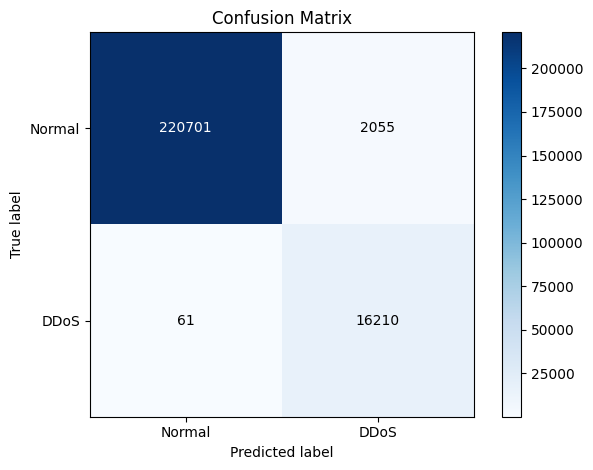

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
tp=eval_results["TP"][1]
fp=eval_results["FP"][1]
tn=eval_results["TN"][1]
fn=eval_results["FN"][1]
confusion_matrix = np.array([[tn, fp], [fn, tp]])

# Define class labels
class_labels = ['Normal', 'DDoS']

# Plot the confusion matrix
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to the plot
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

# Add value annotations to the plot
thresh = confusion_matrix.max() / 2
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j]), ha="center", va="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()